# BIBLE OF A TIME SERIES	

Here we have a repository in which we can learn a lot about time series, a statician field in continuous developement with a completely different view in front of other techniques.

The main concepts we are going to learn:

 - What is a Time Series
 - Decomposition
 - Aditive & Multiplicative Time Series Models
 - Smoothing
 - Transformations of the Time Series
 - Autocorrelation
 - AR & MA Models
 - ARIMA
 - Parameters
 - Modelazing
 - Output interpretation
 - Residual Analysis
 - Model validation

### What is a Time Series?

Time series is a sequence of values recorded and sort in regular time intervals, such as, years, months, days, hours…

Some examples of Time Series:

 - Daily Kw electricity power consumption in a city. 
 - Monthly number of unemployed people in a country.
 - Hourly number of cars in a gas station.

In our case, we are going to use monthly credit card available

The Goal of analysing a Time Series is to forecast and predict the next values for the next time moments. Before that, it is important to understand the main characteristics of the Time Series to manage and build the best model.

These features are trend, seasonality and error. these characteristics are also known as Decomposition of the Time Series.

First of all we input the values and we save them as a pandas DataFrame. Then we visualize them to get a quickly overview.

In [ ]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [46]:
data = pd.read_csv('./data.csv',sep=';')
data['month'] = pd.to_datetime(data['month'], format='%Y%m')
data = data.set_index('month')

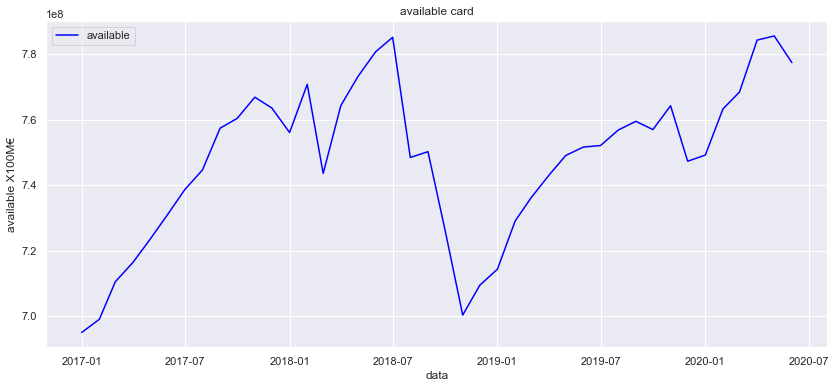

In [45]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.plot(data.available_card, 'blue', label= "available")
plt.title('available card')
plt.ylabel('available X100M€')
plt.xlabel('data')
ax.legend(loc=2)
plt.grid(True)
plt.show()

We have data from January'2017 untill November'2020,
As it is normal there are heavy decreases on christmas due to the consumption increase, maximums are achieved on spring.


### Decomposition

To better understand this kind of data it is desirable to have stationary Series, that is to have constant mean and variance during the entire data, in other words, mean and variance are not function of time.

The way to decompose a Time Series is analysing Trend, Seasonality and error.

Trend can also be defined as an increasing (or decreasing) mean. Seasonality can be defined as a recurring cycle, that is when the series have similar patterns "equaly time distributed". The final component of a time series is the remaining random residual.

In the most part of the time series there is not stationarity, so that is why data scientists need to identify and decompose time series components before apply a model. The most common way to fix this situation is to transform the series in order to obtain a stationary one, then build the model and the last step is to transform it back to obtain the real performance.

There are numerous ways to decompose a time series, such as, classical, X11 and SEATS, but, in my opinion the best, because of his versatility, is STL (Seasonal and Trend decomposition using Loess).

Below we have our decomposition.


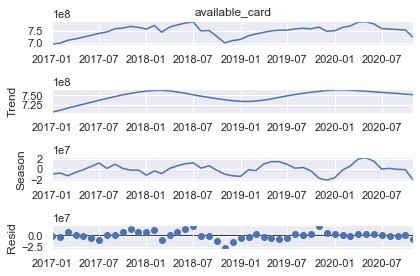

In [8]:
#STL decomposition
series = data.available_card
result = STL(series).fit()
chart = result.plot()
plt.show()

In the first graph we see the Observed values, in second term we have the Trend which is smoother than the observed values.
The last year is quite stable, in spite of what can be concluded watching real data.

The third chart is about Seasonality, here we observe clearer that in every end of the year we have a minimum, and a maximum
in the spring-summer.

### Aditive & Multiplicative Time Series Models

There are two ways of modelize a time series. 

Watching if the amplitude of the series is dependant on the mean. The question is, is the variance increasing when mean does? If not, you should use an additive model, else you should use the multiplicative.

Difference between both models is the operator of every element of the decomposition, trend, seasonality and residuals.

 - Yt = mt + st + Zt,

 - Yt = mt * st * Zt,

When:
 - mt is the trend
 - st is the seasonality
 - Zt is residuals

In our case it is not that easy to found if our mean and variance are independant each other, so let's transform the series in order to have a stationary dataset and then use an additive model.

### Smoothing

Usually, Time series have a lot of increasing and decreasing trends, and it is not that easy to get a conclusion about trend.

So, one of the most common techniques to firstly analyse a Time Series is to smooth it. That is to relativise every value of the Time Series. This view allows us to better understand the trend of our data. The best-known techniques to smooth a Serie are moving average and exponential average.

The simplest smooth and the easiest to understand is the moving average. It consists in calculate the average of the k terms on the left and the k terms on the right of the point we are smoothing. Doing this, we remove the picks that can confuse us about the tendency.

 - mt = (Xt-k + Xt-k+1 + ... + Xt + ... + Xt+k-1 + Xt+k)/(2 * k + 1)

One consequence of this technique is the lost of the first (and last) k terms of the series.

Exponential smoothing only considers the current and the last moment to recalculate the new smoothed value. A constant (α) allows us to parametrize the weight of this two moments. This constant takes values between 0 and 1, the higher the constant higher the weight for the current moment and lower for the previous one. Also, the higher the constant, the more similar than observed data.

 - mt = αXt + (1 − α)Xt−1,
 

It is important to note these smoothing techniques are only useful for analyse our data, not to forecast or estimate or predict.

Next we are going to analyse these two kind of smoothings


In [5]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

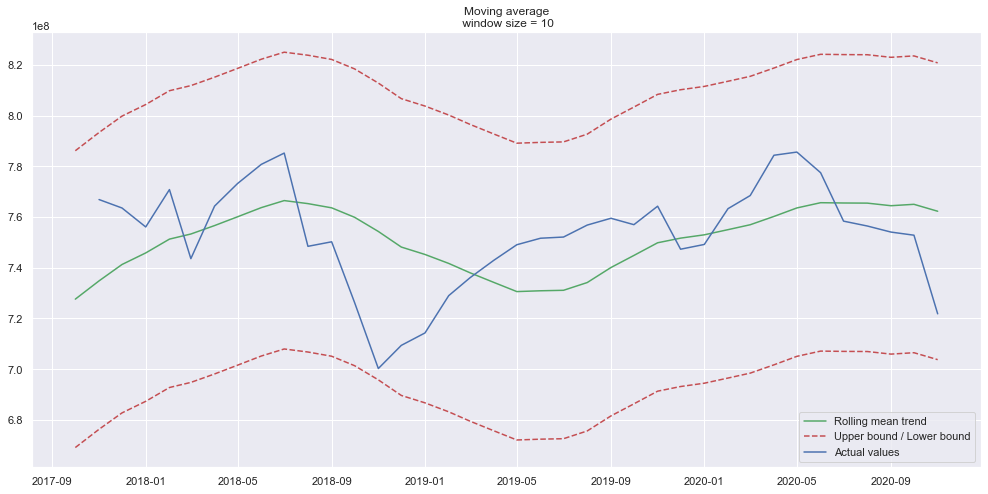

In [6]:
#Smooth by the previous 5 days
plot_moving_average(data.available_card, 10, plot_intervals=True)

In [7]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

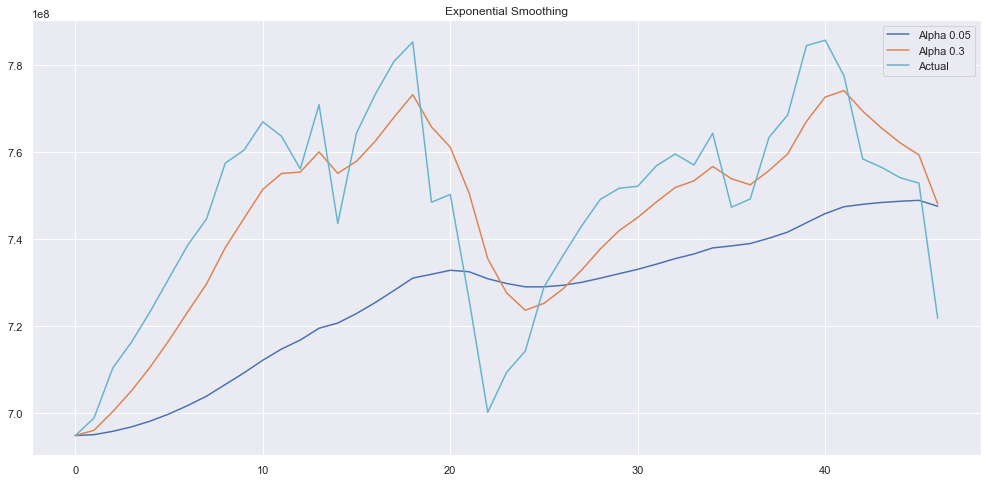

In [8]:
plot_exponential_smoothing(data.available_card, [0.05, 0.3])

### Transformations

In real world most part of the data is not stationary (mean and variance in function of time) so, sometimes it is necessary to transform Time Series to induce these characteristics.

One of the best transformations to control changing variance is the logarithmic.

To manage the growing mean the best way is to make differentiation, which means to transform the current value by subtracting the last one (or k-previous lags) . Sometimes it is necessary to differentiate two times.

How we know if we require some transformation in the series? Answer in the next step


### Autocorrelation 

Time series models based in the past time moments. As a linear regression, it is important to be sure that these values are uncorrelated to get an accurate model.

The most common test to analyse correlation of the Time Series on itself (autocorrelation) is Dickey Fuller. It contrasts the null hypothesis that there is autocorrelation, so if p-value is under 0.05 we consider that there is no correlation between the Y moments. Otherwise, Dickey-Fuller recomends to transform the dataset.

Dickey-Fuller also calculates Autocorrelation and PartialAutocorrelation plots.

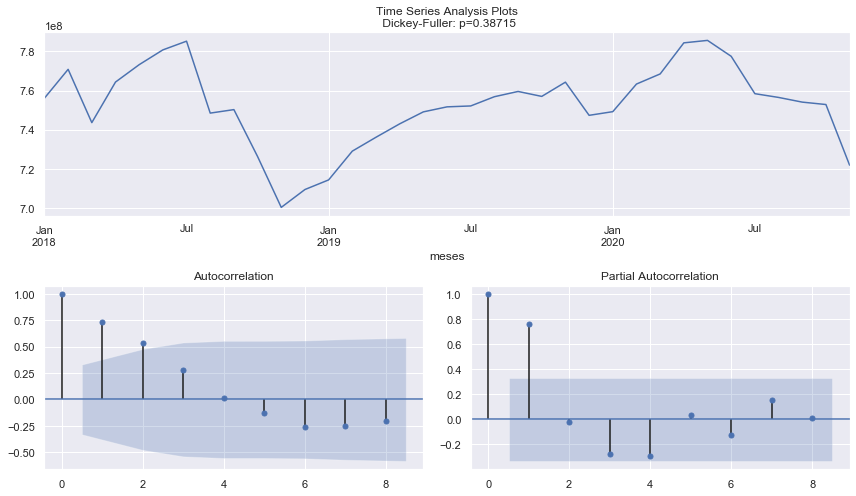

In [187]:
series = data.available_card[12:]

def dickey_fuller_plot(series):
    
    p_value = sm.tsa.stattools.adfuller(series)[1]
    fig = plt.figure(figsize=(12, 7))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    series.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(series, lags=8, ax=acf_ax)
    smt.graphics.plot_pacf(series, lags=8, ax=pacf_ax)
    plt.tight_layout()
    
dickey_fuller_plot(series)

Watching the graphics and the p-value we clearly need some transformation, the original series is not stationaty. Let's start with a logarithmic.

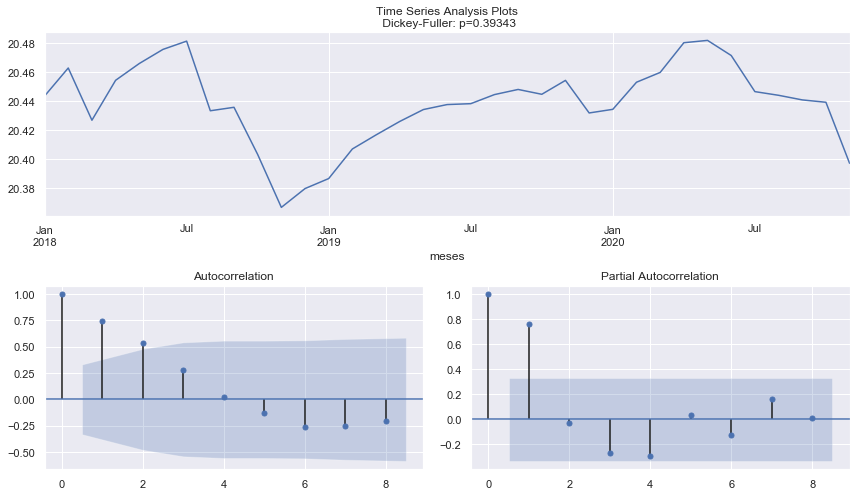

In [188]:
series_T = np.log(series)
dickey_fuller_plot(series_T)

After the logarithmic transformation, the results are similar than the original case, p-value is too big. So, let's try with diferentation.

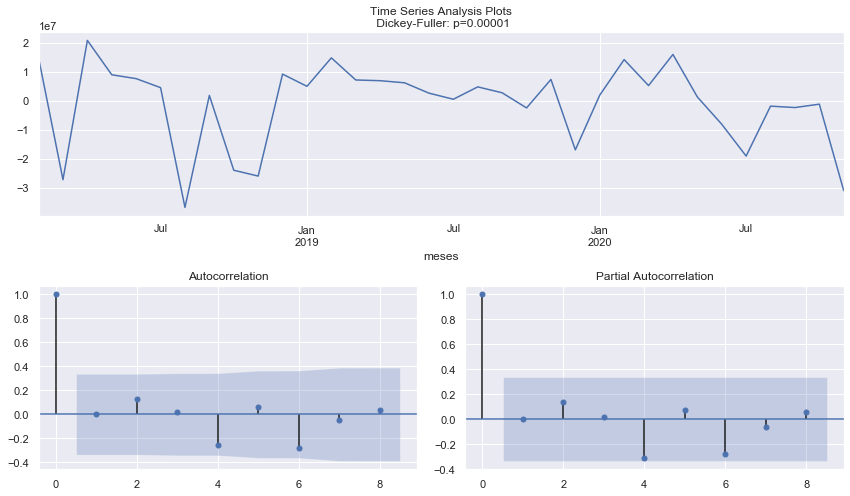

In [189]:
series_T2 = (series - series.shift(1))[1:]
dickey_fuller_plot(series_T2)

Meanwhile, diferentiation performance is much better, we refuse autocorrelation, so, we can continue our analysis using 
this transformed series.

On the other hand, we have the two other charts, correlogram and partial correlogram. 

First one explains internal association between observations, the closer to 1 (or -1) the highest correlation between lags. When correlation in some lag is under the shadow it means that correlation is considered equal to 0, so there is not correlation.

The partial correlogram is a summary of the relationship between an observation in a time series with other prior observation, removing the relationship of observations conteined between them.

In conclusion, any of both plots have no correlation with the previous lags. So, transformed series is uncorrelated.

From now we can start building a time series model, but how? which one...? 


### AR & MA models

AR stands to Auto Regressive (do not mistake with Auto Correlation), so model is built based on the previous lags, we try to find the future value with the information of the last time steps.

MA stands to Moving Average (do not mistake with the smoothing moving average technique). 
We can create a time series from Residual errors, obtained in the forecast of the series, and then we also can model this data. 

Predicting this errors allow us to substract in the AutoRegressive forecasting. So, if on one side, we forecast the next value of the series, and then, we correct it with the error prediction, model provides us an additional fit in performance

To better understand, an autoregression of the residual errors is the Moving Average model.

We can combine these two methodologies and then we will build an ARMA model. 

### FORMULA of the models

### ARIMA models

What happen if series is not stationary? As we explain before, we need to transform it. 

There exists one technique to model series with non-zero autocorrelation indicators. That's ARIMA, which is a combination of AR and MA models but including a parameter which allows us to differenciate the original series. ARIMA stands to AutoRegressive Integrated Moving Average.

So difference between ARMA and ARIMA is that ARIMA includes the differentiation of the series.

### FORMULA of the models

### Parameters

After understand how the models work, it appears the next question, how many time lags we should use to predict the future values?

Every part of the model (AR, MA & differentiator factor) have his own parameter:

 - p is the number of time lags we use to build the AutoRegressive part
 - q is the number of retards of the MA model
 - d is the number of differentiations we will execute

So, in conclusion, what we have is an ARIMA model with parameter p, q and d. When d = 0 the model is just ARMA.




### Modelazing

So, in order to validate the model we will build, we have to split the data in two datasets, one for training the model, the other one to validate it, to compare model prediction with real data.

After that, let's finally build the model. We will try with different parameters p,d and q. Next we show the best.


In [10]:
series = data.available_card
#dispo_train = series.iloc[0:40]
series_T = (series - series.shift(1))[1:]
dispo_train = series.iloc[0:30]
dispo_test = series.iloc[30:42]
dispo_test

meses
2019-07-01    752123901
2019-08-01    756846940
2019-09-01    759533262
2019-10-01    757006903
2019-11-01    764295495
2019-12-01    747325848
2020-01-01    749201905
2020-02-01    763324269
2020-03-01    768498146
2020-04-01    784396321
2020-05-01    785652677
2020-06-01    777512682
Name: available_card, dtype: int64

In [245]:
model = ARIMA(dispo_train, order=(2,1,2))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.available_card   No. Observations:                   29
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -513.169
Method:                       css-mle   S.D. of innovations       10951559.241
Date:                Thu, 21 Jan 2021   AIC                           1038.339
Time:                        17:54:34   BIC                           1046.542
Sample:                    02-01-2017   HQIC                          1040.908
                         - 06-01-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.957e+06   3.21e+06      0.610      0.542   -4.33e+06    8.25e+06
ar.L1.D.available_card     0.6922      0.243      2.846      0.004       0.216       1.169
ar.L

### Output interpretation

"coef" column shows us the size and the direction of the relationship between the time lag you want to predict and k-previous explanatory time lags.

This coefficient describes the increase in the response for every unit of increase in the explanatory time lag.

Next column, standard error, calculates the precision of the estimation of the coefficient, that is, the smaller this value, the more precision has the coefficient. 

Then the system calculates the z-value by dividing the coefficient by his standard error. To know if the coefficient is statistically significant (different from zero) we have to analyse if the p-value associated with this z-value is lower than our significance level (0.05), if yes, we consider that the coefficient is different from zero, so it is significant and we have to keep it in the model.

Z- distribution follows a Normal, with mean zero and standard desviation equal to 1, when z-value is in the tail (greatest values) it is considered different from zero.  

In the ARIMA Model Results table, we input an ARIMA(2,1,2), and we see that the coeficients are statistically different from zero (P>|Z| < 0.05), so we keep them in the model.

Here, we only have the output of the best model, but we made a lot of tests, changing the parameters, watching indicators in every execution, until we conclude this is the best. To determine which model is the best we look at the Log likelihood estimator, which is related with AIC. 

 - AIC = 2 k – 2 ln(L)

While K is the number of terms.

Greater the LogLikelihood lower the AIC. These indicators are often used to compare two models, for example an ARIMA(2,1,2) with an ARIMA(2,0,2), we consider better model the one with a lower AIC.

In clonclusion, we choose the ARIMA(2,1,2) because of the good significance of the coefficients and the lowest AIC.

### Residual analysis

Residuals are the difference between fitted and observed values. It is very important to analyse them, because they can give us information about how the model is fitting. There are two main proprerties that residuals have to achieve.

First one, residuals must be uncorrelated between them. If not, it means that exists information, which is not being used, remaining in the residuals. On the other hand, residuals must have mean zero. If these two requests are not meet, our model have not capture adequately the information.

We plot the distribution and density of the residuals. 


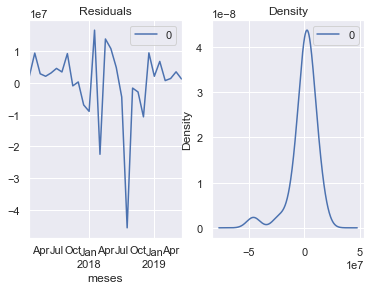

In [224]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Model validation

From here we will analyse the goodness of fit, that's how the model is fitted to the observed data.
In the first step, we plot the entire training data and its forecast.

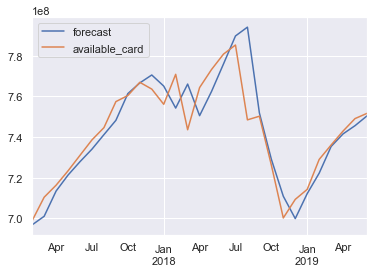

In [228]:
model_fit.plot_predict(dynamic=False)
plt.show()

Next, we use cross-validation in order to validate the model, that is to compare predicted values with observed in the test data set. We see it in a chart, which is very explanatory 

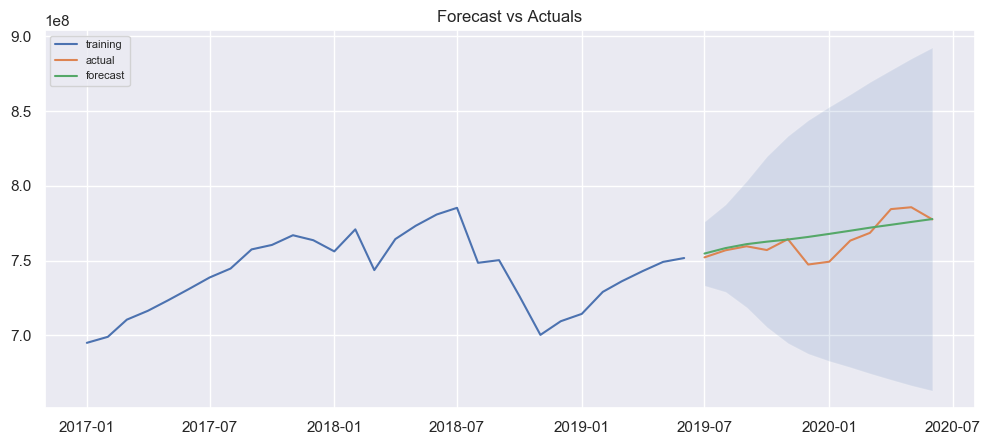

In [233]:
# Forecast
fc, se, conf = model_fit.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dispo_test.index)
lower_series = pd.Series(conf[:, 0], index=dispo_test.index)
upper_series = pd.Series(conf[:, 1], index=dispo_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(dispo_train, label='training')
plt.plot(dispo_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As we see, the green line, the forecast, is quite close to test data, which is good. But, the best way to quantify how good the model is with the next accuracy metrics:

 - MAPE Mean Absolute Percentage Error
 - MAE Mean Absolute Error
 - RMSE Root Mean Square Error
 
The three have good levels. MAPE is equal to 0.8% and RMSE is around 9 Millions (it can seem a lot but the observed data scale is around 770 Millions)

Note that, from the 3th prediction, forecasts are estimated on the last two predictions (not observed values). Because our model is an ARIMA(2,1,2).

In [235]:
mape = np.mean(np.abs(fc - dispo_test.values)/np.abs(dispo_test.values))
mae = np.mean(np.abs(fc - dispo_test.values))    
rmse = np.mean((fc - dispo_test.values)**2)**.5  

print({'mape':mape,'mae': mae,'rmse':rmse})


{'mape': 0.008654009391928187, 'mae': 6584060.684538871, 'rmse': 9094713.337688752}


In [237]:
# Here we print forecast and test values

frcst = pd.DataFrame({'meses':meses[30:42],'frcst':fc,'test':dispo_test, 'dif': fc-dispo_test})
frcst['meses'] = pd.to_datetime(frcst['meses'], format='%Y%m')
frcst = frcst.set_index('meses')
frcst

,frcst,test,dif
meses,,,
2019-07-01,7.546638e+08,752123901,2.539877e+06
2019-08-01,7.583075e+08,756846940,1.460552e+06
2019-09-01,7.609534e+08,759533262,1.420142e+06
2019-10-01,7.626165e+08,757006903,5.609635e+06
2019-11-01,7.640552e+08,764295495,-2.403159e+05
2019-12-01,7.657874e+08,747325848,1.846152e+07
2020-01-01,7.678253e+08,749201905,1.862339e+07
2020-02-01,7.699408e+08,763324269,6.616507e+06
2020-03-01,7.719703e+08,768498146,3.472124e+06
